In [270]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


nx = 9
ny = 6

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension



In [140]:
def convert_image(image, img_format):
    #convert to grayscale
    if img_format == 'gray':
        #print("convert to grayscale")
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return gray
    elif img_format == 'hls':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        return hls

In [129]:
def detect_corners(img):
    global objpoints, imgpoints
    #print(nx,  ny)
    #print(gray.shape)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    #convert to grayscale
    gray = convert_image(img, 'gray')
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #print( ret, corners)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)



In [131]:
#calibration and undistortion

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

found  20  images


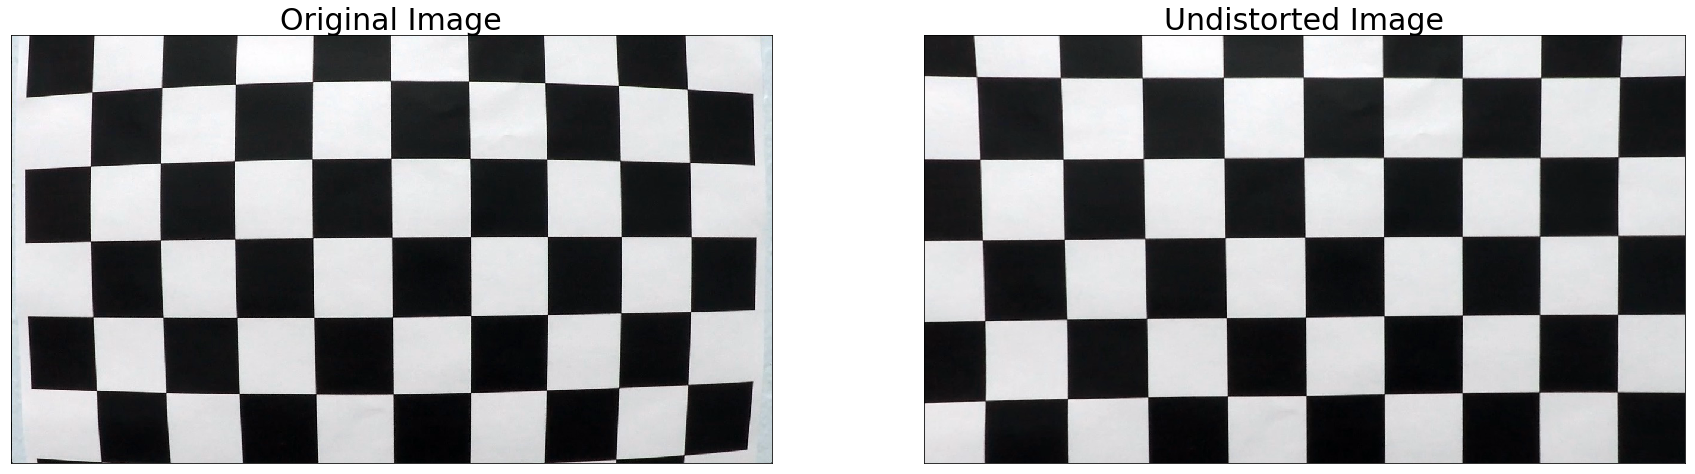

In [138]:
%matplotlib inline

#test calibration
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
print("found ", len(images), " images")


# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    #print("calibrate image ", fname)
    
    img = cv2.imread(fname)
    #print('original shape',img.shape)

    #find corners 
    detect_corners(img)

    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,20), subplot_kw={'xticks': [], 'yticks': []})
 
# test calibration on the first image
img = cv2.imread('camera_cal/calibration1.jpg')
 
img_size = (img.shape[1], img.shape[0])
#print(img_size)
 
dst = undistort(img)

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
    
    

found  8  images


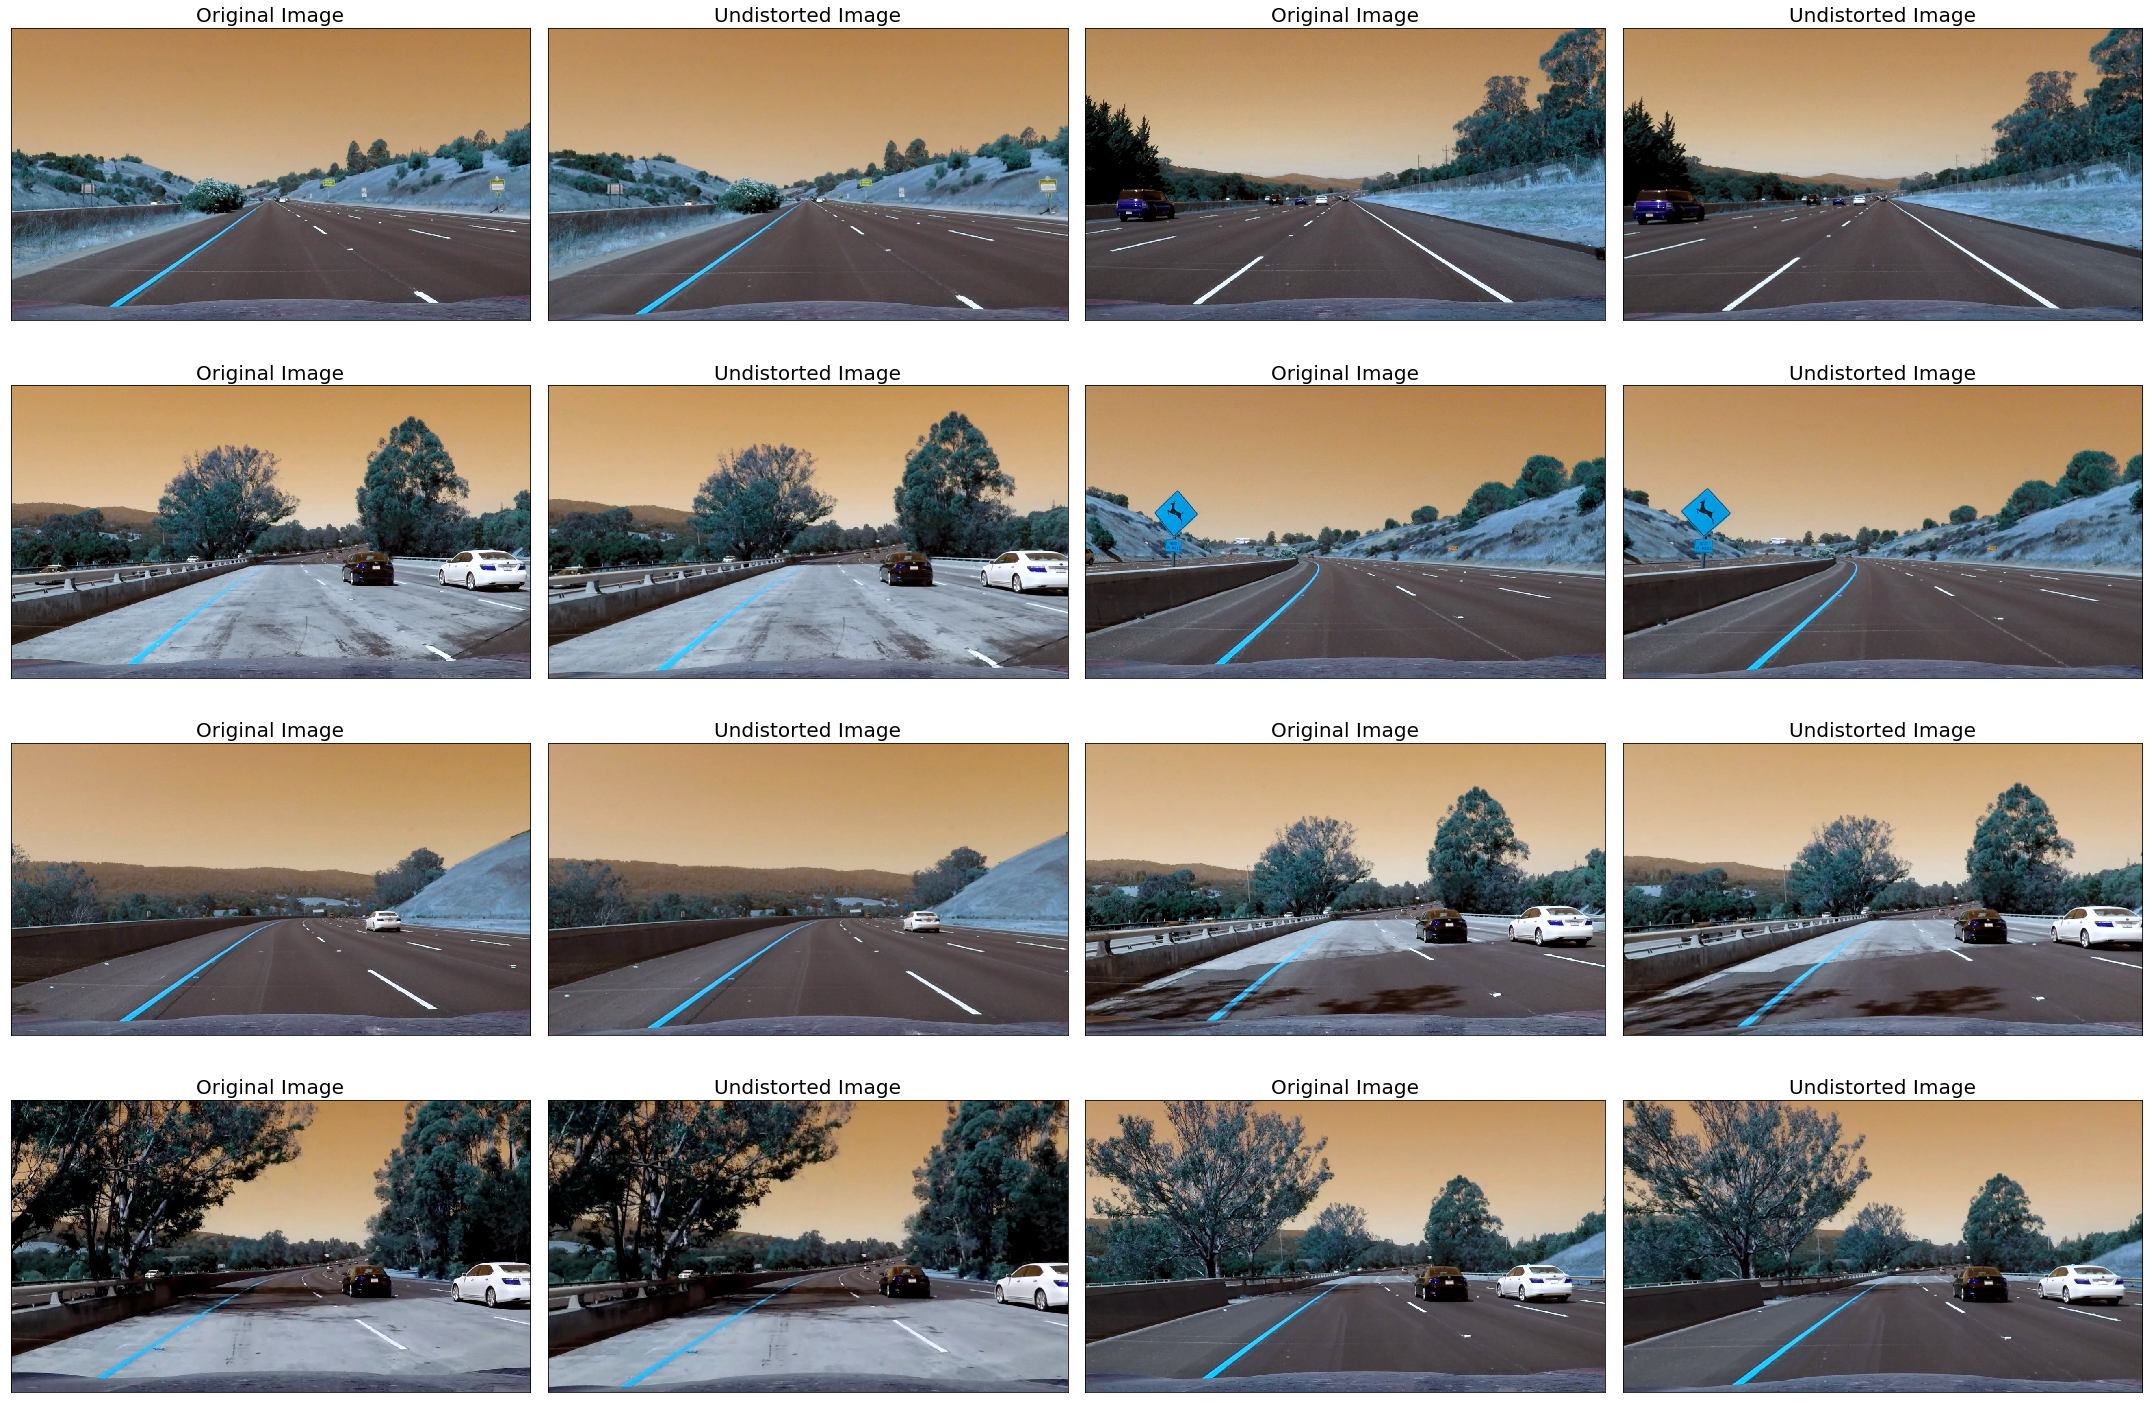

In [139]:
#test calibration on test images
images = glob.glob('test_images/*.jpg')
print("found ", len(images), " images")

f, axes = plt.subplots(4, 4, figsize=(30,20), subplot_kw={'xticks': [], 'yticks': []})
f.tight_layout()
axes = axes.ravel()
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    #print("calibrate image ", fname)
    
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    #print(img_size)
 
    dst = undistort(img)

    axes[idx*2].imshow(img)
    axes[idx*2].set_title('Original Image', fontsize=20)
    axes[idx*2+1].imshow(dst)
    axes[idx*2+1].set_title('Undistorted Image', fontsize=20)


In [190]:
def color_thresh(img):
    # Threshold color channel
    s_thresh_min = 125
    s_thresh_max = 255

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = convert_image(img, 'hls')
    s_channel = hls[:,:,2]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    return s_binary
    
def abs_sobel_thresh(img):    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = convert_image(img, 'gray')

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 25
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary
    
def threshold_binary_image(img, showimage = False):
    s_binary = color_thresh(img)
    sxbinary = abs_sobel_thresh(img)
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    if showimage == True:
        # Plotting thresholded images
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.set_title('Original')
        ax1.imshow(img)

        ax2.set_title('Stacked thresholds')
        ax2.imshow(color_binary)

        ax3.set_title('Combined S channel and gradient thresholds')
        ax3.imshow(combined_binary, cmap='gray')
    return combined_binary

array([[1, 1, 1, ..., 1, 1, 0],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 1, 0],
       ..., 
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

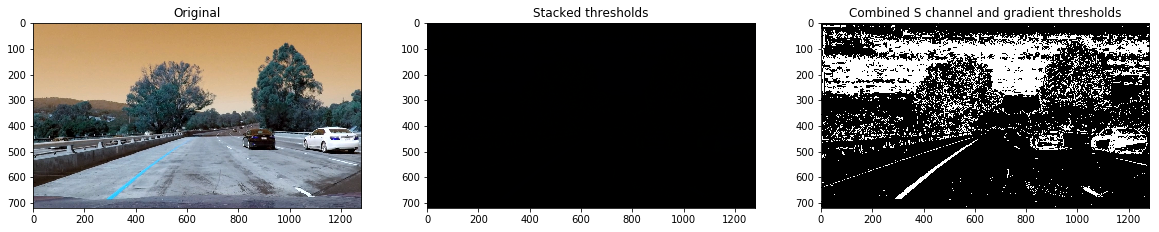

In [191]:
#test color transform, gradient
img = cv2.imread('test_images/test1.jpg')
threshold_binary_image(img, True)

In [295]:
def unwarp(img):
    img_size = (img.shape[1], img.shape[0])

    # Source points - defined area of lane line edges
    #src = np.float32([(570,464),
    #                  (707,464), 
    #                  (260,664), 
    #                  (1050,664)])
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
                    [((img_size[0] / 6) - 10), img_size[1]],
                    [(img_size[0] * 5 / 6) + 60, img_size[1]],
                    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    offset = 100
    #dst = np.float32([[offset, offset], 
    #                  [img_size[0]-offset, offset], 
    #                  [img_size[0]-offset, img_size[1]-offset], 
    #                  [offset, img_size[1]-offset]])
    dst = np.float32([[(img_size[0] / 4), 0],
                    [(img_size[0] / 4), img_size[1]],
                    [(img_size[0] * 3 / 4), img_size[1]],
                    [(img_size[0] * 3 / 4), 0]])

    #Compute the perspective transform, M, given source and destination points
    M = cv2.getPerspectiveTransform(src, dst)
    #Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    #Warp an image using the perspective transform, M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

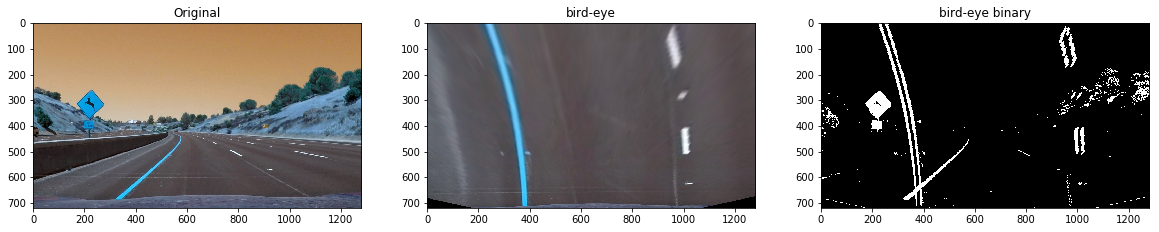

In [296]:
#test warp
img = cv2.imread('test_images/test2.jpg')

dst_img = undistort(img)
warped, Minv = unwarp(dst_img)
binary = threshold_binary_image(warped)


#threshold_binary_image(img, True)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(img)

ax2.set_title('bird-eye')
ax2.imshow(warped, cmap='gray')

ax3.set_title('bird-eye binary')
ax3.imshow(binary, cmap='gray')



In [298]:
def finding_lane_and_offset(binary_warped, visualization=False):
    global xm_per_pix
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #print(win_xleft_low,win_y_low,win_xleft_high,win_y_high)
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high ))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
 
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #determine offset
    car_center = binary_warped.shape[0]/2
    lane_center = (left_fitx + right_fitx)/2
    offset = (car_center - lane_center) * xm_per_pix
    
    if ( visualization == True):
 
        #for rect in rectangle_data:
            # Draw the windows on the visualization image
        #    print(rect)
        #    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
        #    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
        # Write the results on images using OpenCV 
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_size = 1.5
        color = (255,255,255)
        text_left = "{:6.5}y^2+{:6.5}y+{:6.5}".format(left_fit[0],left_fit[1],left_fit[2])
        cv2.putText(out_img, text_left, (20, 100), font, font_size, color, 2)
        text_right = "{:6.5}y^2+{:6.5}y+{:6.5}".format(right_fit[0],right_fit[1],right_fit[2])
        cv2.putText(out_img, text_right, (360, 600), font, font_size, color, 2)    
    
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return ploty, left_fitx, right_fitx, offset

C:\Users\yoeli\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


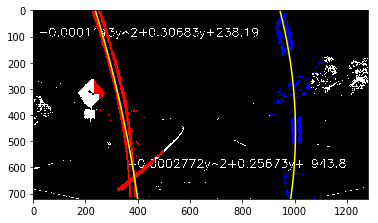

In [299]:
#test finding lanes
img = cv2.imread('test_images/test2.jpg')

dst_img = undistort(img)
warped, Minv = unwarp(dst_img)
binary = threshold_binary_image(warped)
ploty, leftx, rightx, offset = finding_lane_and_offset(binary, True)

In [300]:
def find_curvature(ploty, leftx, rightx):
    global xm_per_pix, ym_per_pix
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')

In [301]:
#test finding curve
img = cv2.imread('test_images/test2.jpg')

dst_img = undistort(img)
warped, Minv = unwarp(dst_img)
binary = threshold_binary_image(warped)
ploty, leftx, rightx, offset = finding_lane_and_offset(binary)
find_curvature(ploty, leftx, rightx)

1437.51608556 m 592.740988467 m


C:\Users\yoeli\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [302]:
def drawing_lane(undist, binary_warped, ploty, left_fitx, right_fitx, Minv):
    
    img_size = (undist.shape[1], undist.shape[0])
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)

C:\Users\yoeli\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


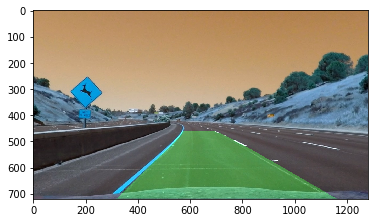

In [303]:
# t#test finding curve
img = cv2.imread('test_images/test2.jpg')

dst_img = undistort(img)
warped, Minv = unwarp(dst_img)
binary = threshold_binary_image(warped)
ploty, leftx, rightx, offset = finding_lane_and_offset(binary)
drawing_lane(dst_img, binary, ploty, leftx, rightx, Minv)

In [304]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

left_line = Line()
right_line = Line()

In [ ]:
def pipeline(image):
    global left_line, right_line
    
    dst_img = undistort(img)
    warped, Minv = unwarp(dst_img)
    binary = threshold_binary_image(warped)
    
    if left_line.detected == False and right_line.detected == False:
        left_line.detected = True
        right_line.detect = True
        ploty, leftx, rightx, offset = finding_lane_and_offset(binary)
        
    else:

    find_curvature(ploty, leftx, rightx)
        
    drawing_lane(dst_img, binary, ploty, leftx, rightx, Minv)

In [ ]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)